In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
market_features = pd.read_csv('all_features_BTCUSDT.csv', index_col=0, parse_dates=[0], low_memory=False)
market_features = market_features.resample('D').ffill()
market_features = market_features.loc[:, market_features.isna().mean() <= 0.7]

strategies_data = {}
returns_features_path = 'returns_features'
for file in os.listdir(returns_features_path):
    if file.endswith('_returns_features.csv'):
        strategy_name = file.replace('_returns_features.csv', '')
        df = pd.read_csv(os.path.join(returns_features_path, file), index_col=0, parse_dates=[0], low_memory=False)
        df = df.resample('D').ffill()
        df['Sharpe_Ratio_Target'] = (df['Sharpe_Ratio_1_30'].shift(-1) > 0).astype(int)
        df['Mean_Returns_Target'] = (df['Mean_Returns_1'].shift(-1) > 0).astype(int)
        df = df[:-1]
        strategies_data[strategy_name] = df




merged_data = {}
for strategy, df in strategies_data.items():
    merged_df = pd.merge(market_features, df, left_index=True, right_index=True, how='inner')
    merged_df = merged_df.dropna(axis=1, thresh=0.5 * len(merged_df))
    merged_df = merged_df.dropna()
    merged_data[strategy] = merged_df

In [4]:
# frequency for walk-forward steps
train_end = '2023-12-31'
predict_start = '2024-01-01'
predict_end = '2024-03-31'

step = pd.DateOffset(months=1)

In [5]:
def compute_average_metrics(results):
    average_metrics = {}
    for strategy, models_dict in results.items():
        average_metrics[strategy] = {}
        for model, metrics_list in models_dict.items():
            if metrics_list:
                df_metrics = pd.DataFrame(metrics_list)
                avg_metrics = df_metrics[['Accuracy', 'Precision', 'Recall', 'F1_Score']].mean().to_dict()
            else:
                avg_metrics = {'Accuracy': None, 'Precision': None, 'Recall': None, 'F1_Score': None}
            average_metrics[strategy][model] = avg_metrics

    return average_metrics

def plot_average_metrics(average_metrics, metric='F1_Score'):
    plot_data = []
    for strategy, models_dict in average_metrics.items():
        for model, metrics in models_dict.items():
            if metrics[metric] is not None:
                plot_data.append({
                    'Strategy': strategy,
                    'Model': model,
                    metric: metrics[metric]
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Strategy', y=metric, hue='Model')
    plt.title(f'Average {metric} by Model and Strategy')
    plt.xlabel('Strategy')
    plt.ylabel(metric)
    plt.ylim(0, 1)  
    plt.legend(title='Model')
    plt.show()

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

### Returns

In [98]:
 target = 'Mean_Returns_Target'

In [99]:
strategies = merged_data.keys()
dfs = {}

for strategy in strategies:
    df = merged_data[strategy]
    X = df.drop([f'{target}'], axis=1)
    y = df[f'{target}']
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances.sort_values(ascending=False, inplace=True)
    
    top_features = importances.nlargest(15).index
    
    X_selected = X[top_features]
    dfs[strategy] = pd.merge(X_selected, y, left_index=True, right_index=True, how='inner')

In [100]:
models = {
        'RandomForest': rf,
        'CatBoost': cat,
        'LightGBM': lgbm
    }
results_returns = {strategy: {model: [] for model in models.keys()} for strategy in strategies}
for strategy in strategies:
    df = dfs[strategy].copy()
    
    current_train_end = pd.to_datetime(train_end)
    current_predict_start = pd.to_datetime(predict_start)
    current_predict_end = pd.to_datetime(predict_end)
    
    while current_predict_start <= df.index.max():        
        train = df.loc[:current_train_end]
        predict = df.loc[current_predict_start:current_predict_end]
        
        X_train = train.drop(target, axis=1)
        y_train = train[f'{target}']
        
        X_predict = predict.drop(target, axis=1)
        y_true = predict[f'{target}']

        
        for model_name, model in models.items():
            try:
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_predict)
                
                acc = accuracy_score(y_true, y_pred)
                prec = precision_score(y_true, y_pred, zero_division=0)
                rec = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                
                results_returns[strategy][model_name].append({
                    'Model': model_name,
                    'Train_End': current_train_end.date(),
                    'Predict_Start': current_predict_start.date(),
                    'Predict_End': current_predict_end.date(),
                    'Accuracy': acc,
                    'Precision': prec,
                    'Recall': rec,
                    'F1_Score': f1
                })
            except:
                continue
        
        current_train_end = current_predict_end
        current_predict_start = current_train_end + pd.Timedelta(days=1)
        current_predict_end = current_predict_start + step - pd.Timedelta(days=1)
        
        if current_predict_end > df.index.max():
            current_predict_end = df.index.max()

G44

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G85_V1

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G24

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G59_V2

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30


No objects info loaded



Training up to 2024-06-30, predicting from 2024-07-01 to 2024-08-27
G70_V1

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G58_V1

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G33_V1

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G73

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Training up to 2024-03-31, predicting from 2024-04-01 to 2024-06-30

Training up to 2024-06-30, predicting from 2024-07-01 to 2024-09-30
G43

Training up to 2023-12-31, predicting from 2024-01-01 to 2024-03-31

Trai

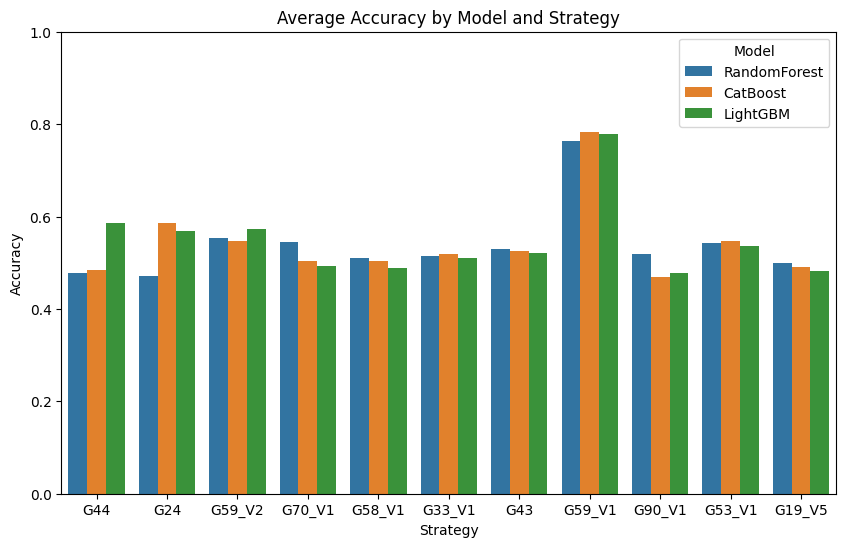

In [110]:
average_metrics = compute_average_metrics(results_returns)
plot_average_metrics(average_metrics, metric='Accuracy')

### Sharpe

In [23]:
target = 'Sharpe_Ratio_Target'

strategies = merged_data.keys()
dfs = {}
def leave_important(X_train, y_train, X_test, n):
    # if n=0 leave all features
    if n > 0:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        importances.sort_values(ascending=False, inplace=True)
    
        top_features = importances.nlargest(n).index
        X_train_selected = X_train[top_features]
        X_test_selected = X_test[top_features]
    else:
        X_train_selected = X_train
        X_test_selected = X_test
    
    return X_train_selected, X_test_selected, importances

## Top n features

In [26]:
models = {
        #'RandomForest': rf,
        'CatBoost': cat,
        'LightGBM': lgbm
    }
results_sharpe = {strategy: {model: [] for model in models.keys()} for strategy in strategies}
feature_importances_dict = {}

for strategy in strategies:
    df = merged_data[strategy].copy()
    
    current_train_end = pd.to_datetime(train_end)
    current_predict_start = pd.to_datetime(predict_start)
    current_predict_end = pd.to_datetime(predict_end)

    strategy_importances = []
    
    while current_predict_start <= df.index.max():        
        train = df.loc[:current_train_end]
        predict = df.loc[current_predict_start:current_predict_end]
        
        X_train = train.drop(target, axis=1)
        y_train = train[f'{target}']
        
        X_predict = predict.drop(target, axis=1)
        y_true = predict[f'{target}']
        if len(X_train) > 0:
            X_train_selected, X_predict_selected, importances = leave_important(X_train, y_train, X_predict, n=15)
            strategy_importances.append(importances)
            
        for model_name, model in models.items():
            try:
                if model_name == 'RandomForest':
                    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
                elif model_name == 'CatBoost':
                    model = CatBoostClassifier(verbose=0, random_state=42, auto_class_weights='Balanced')
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=-1)
                
                model.fit(X_train_selected, y_train)
                
                y_pred = model.predict(X_predict_selected)
                
                acc = accuracy_score(y_true, y_pred)
                prec = precision_score(y_true, y_pred, zero_division=0)
                rec = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                
                results_sharpe[strategy][model_name].append({
                    'Model': model_name,
                    'Train_End': current_train_end.date(),
                    'Predict_Start': current_predict_start.date(),
                    'Predict_End': current_predict_end.date(),
                    'Accuracy': acc,
                    'Precision': prec,
                    'Recall': rec,
                    'F1_Score': f1
                })
            except:
                continue      
        current_train_end = current_predict_end
        current_predict_start = current_train_end + pd.Timedelta(days=1)
        current_predict_end = current_predict_start + step - pd.Timedelta(days=1)
        
        if current_predict_end > df.index.max():
            current_predict_end = df.index.max()
    try:
        feature_importances_dict[strategy] = pd.concat(strategy_importances, axis=1).mean(axis=1)
    except:
        continue

No objects info loaded
/home/alemish/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/alemish/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No objects info loaded
/home/alemish/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/alemish/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No objects info loaded
/home/alemish/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/alemish/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountere

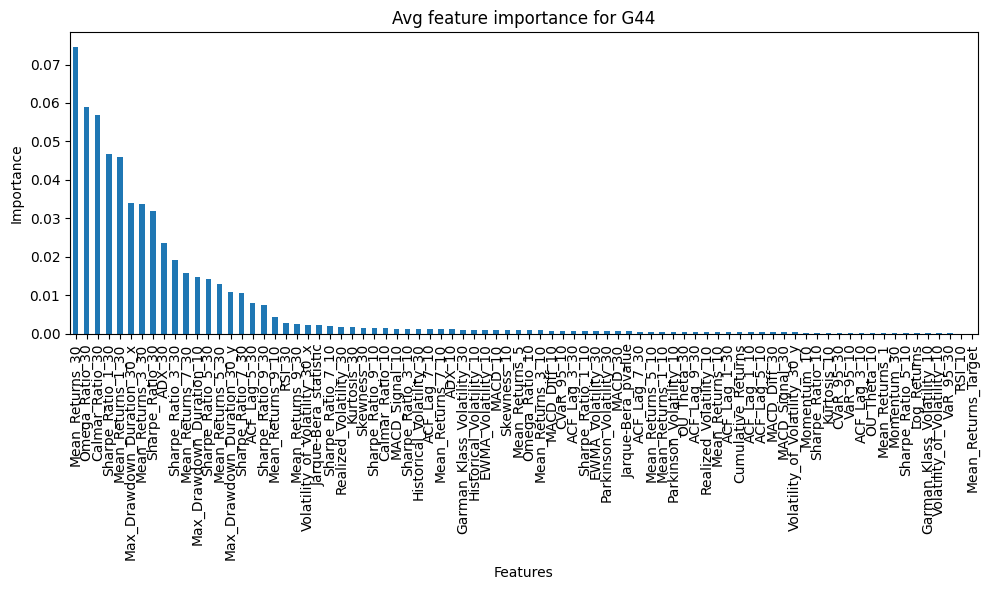

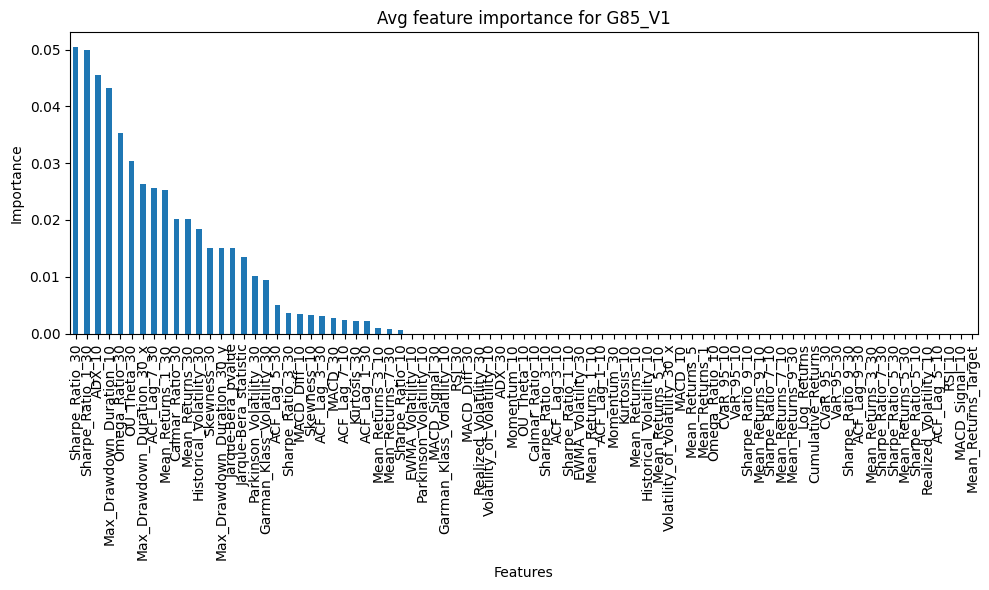

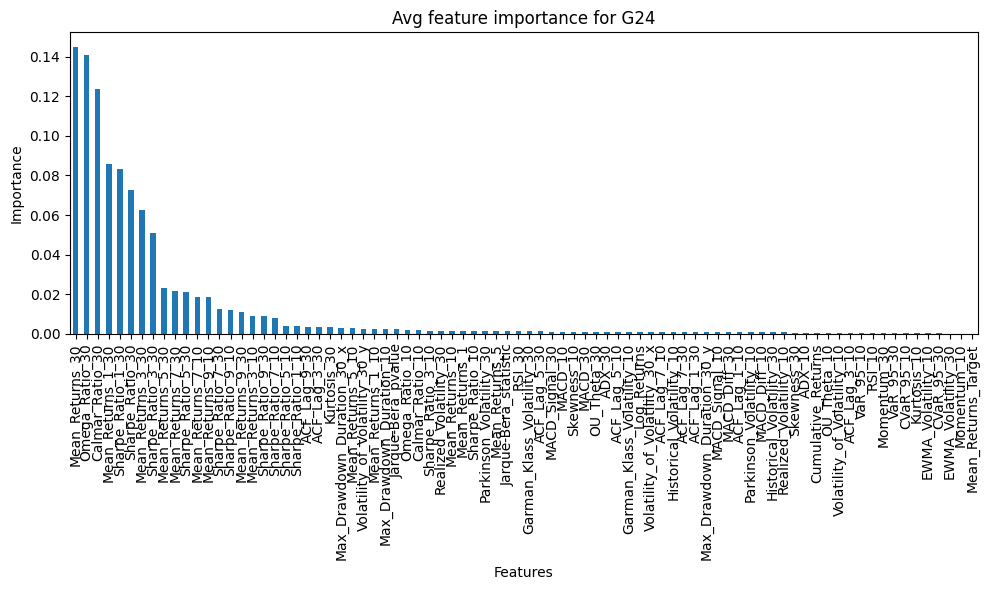

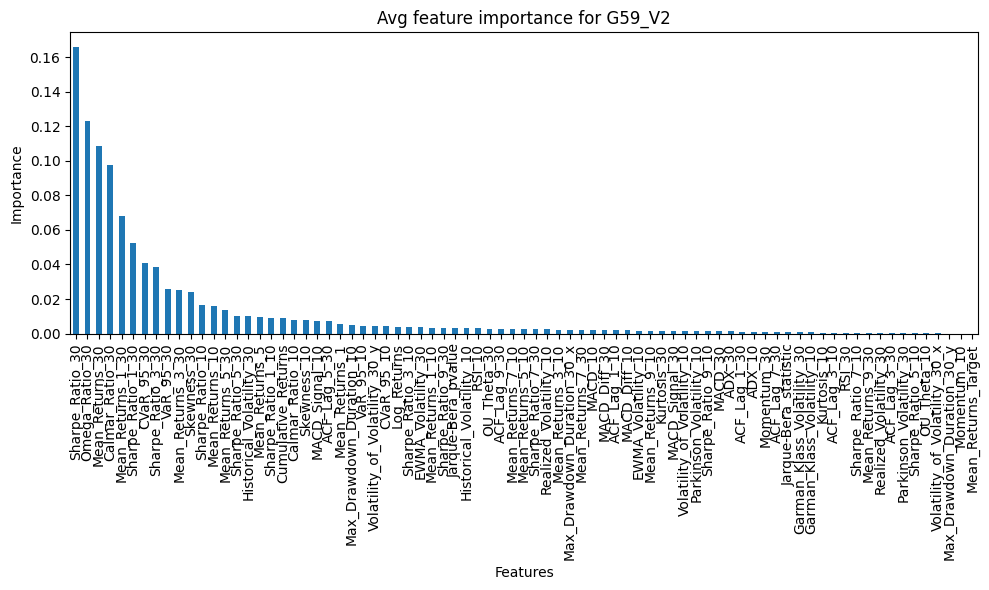

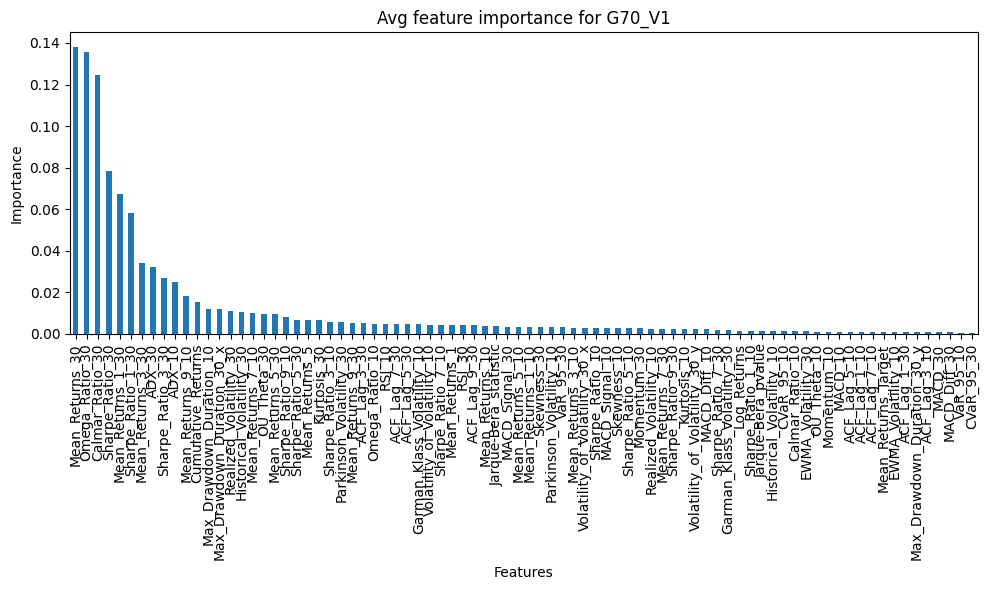

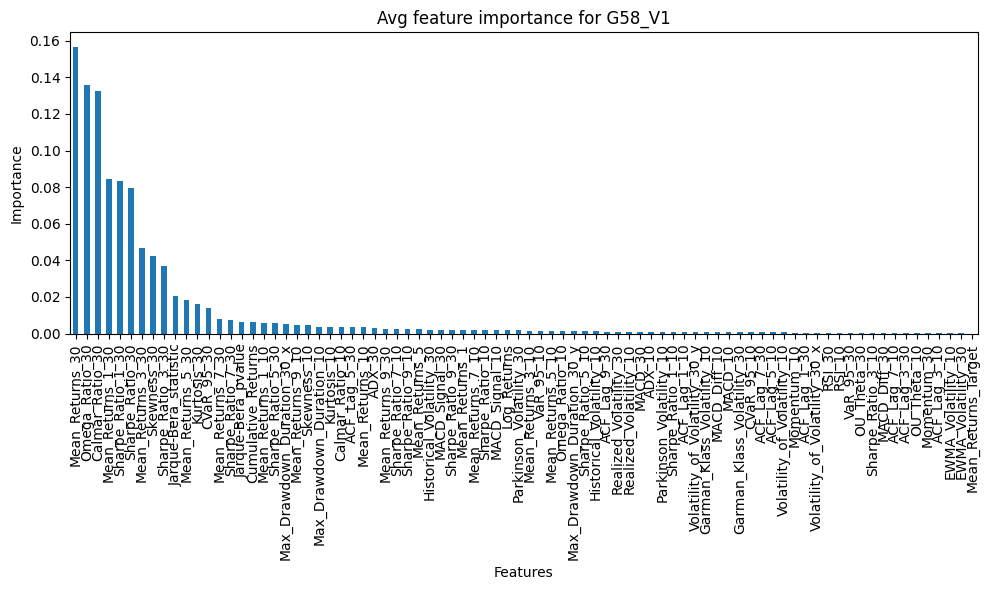

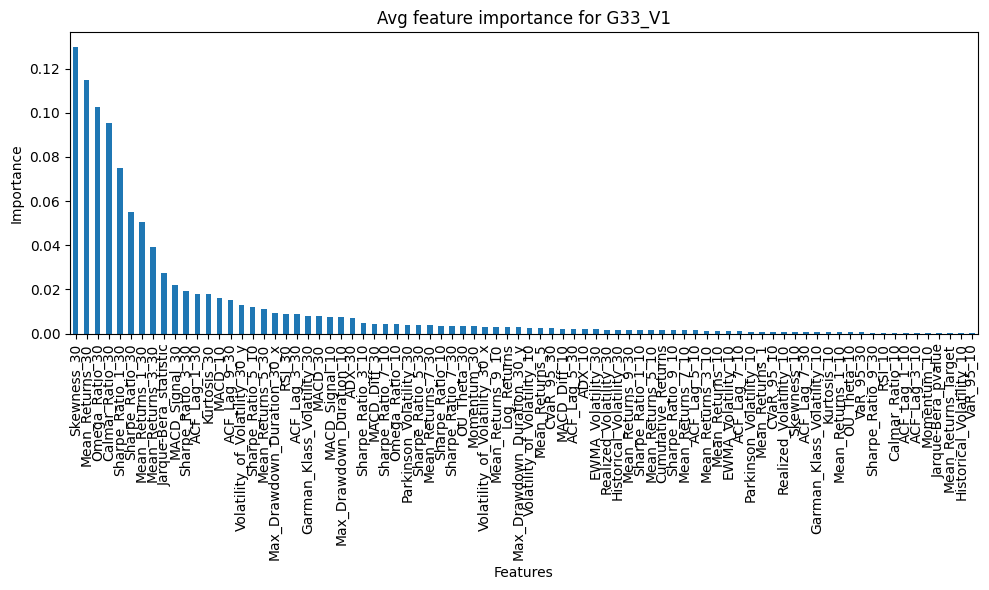

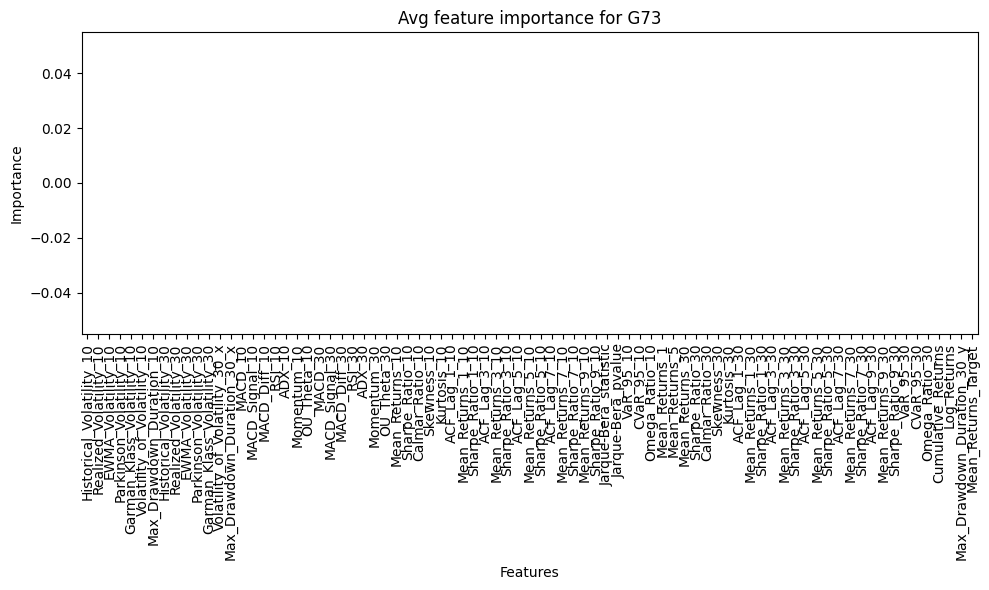

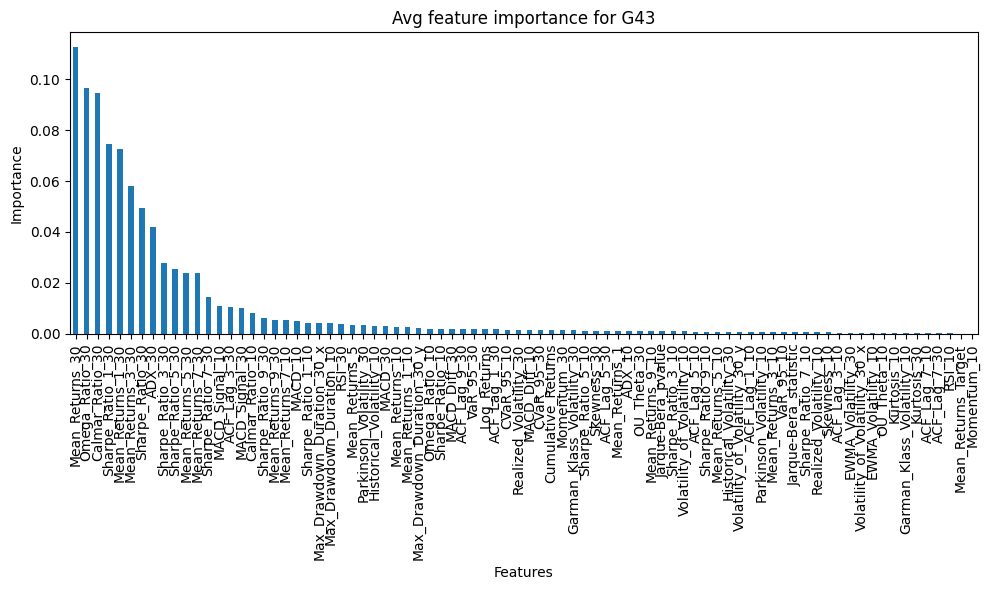

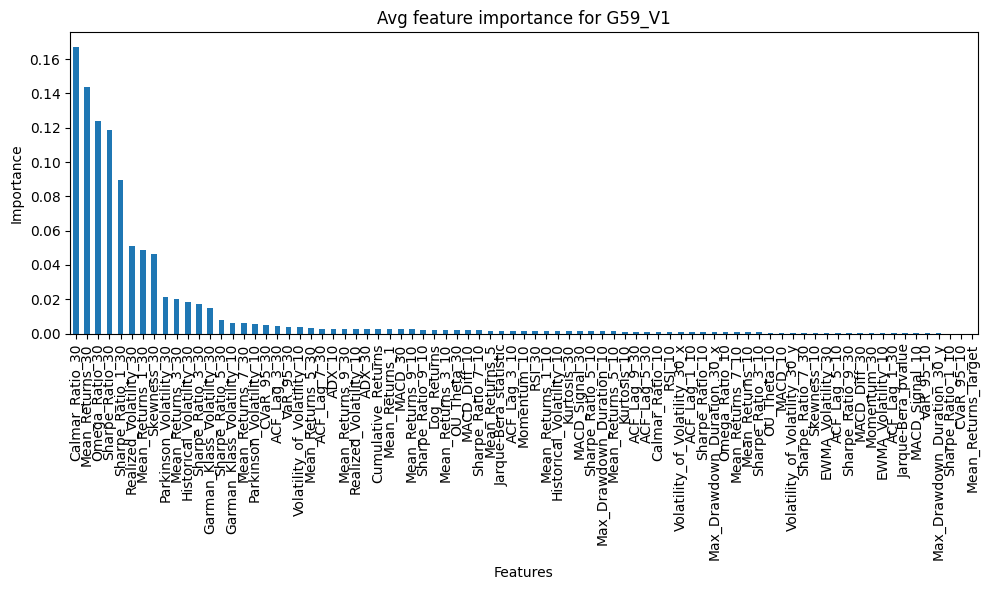

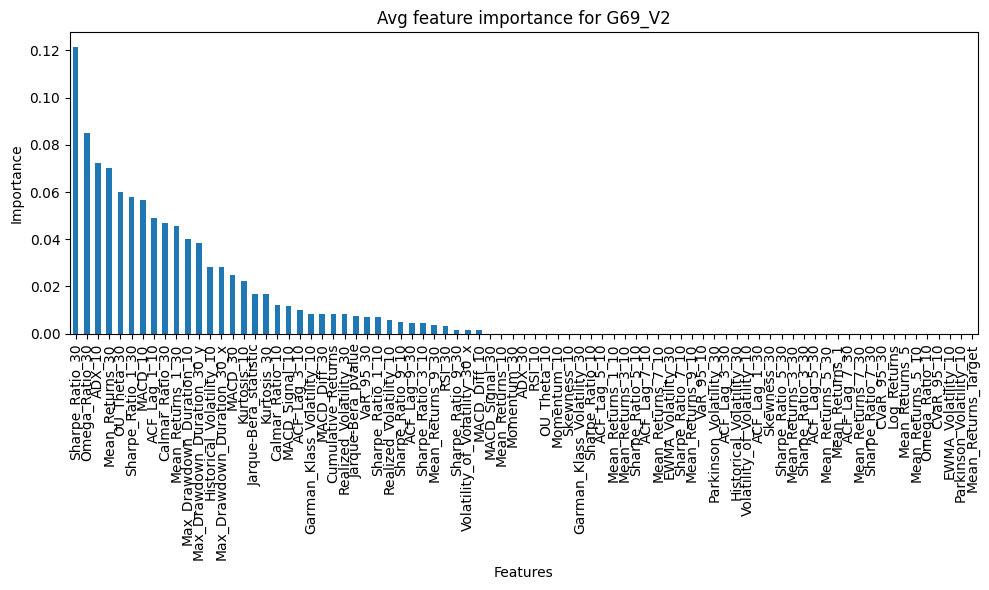

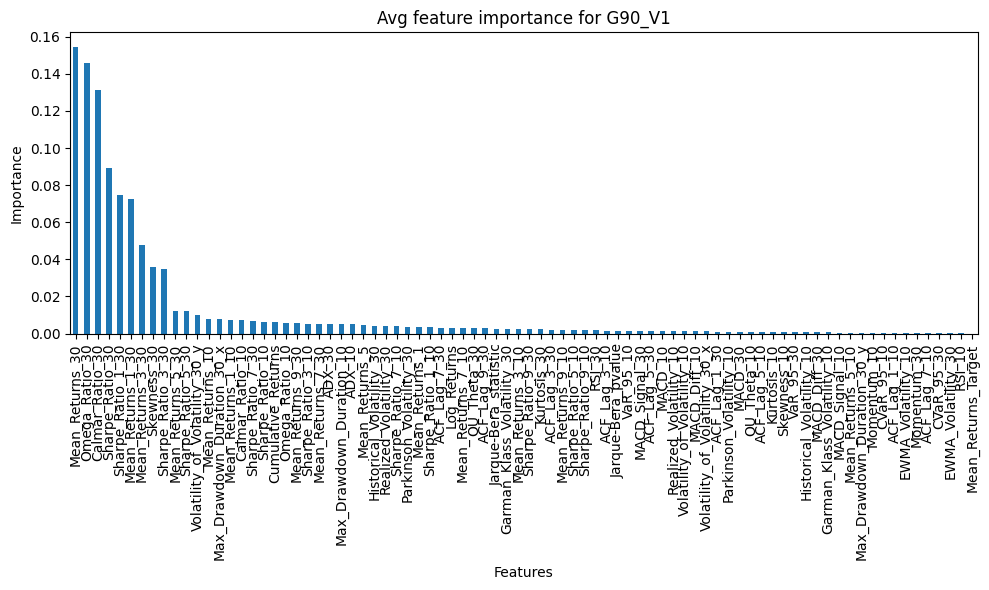

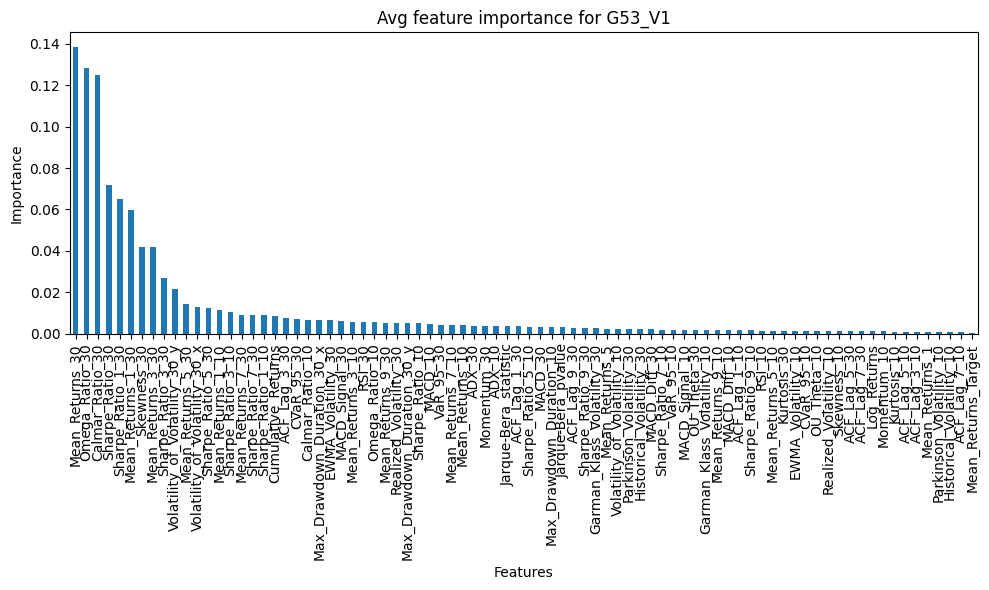

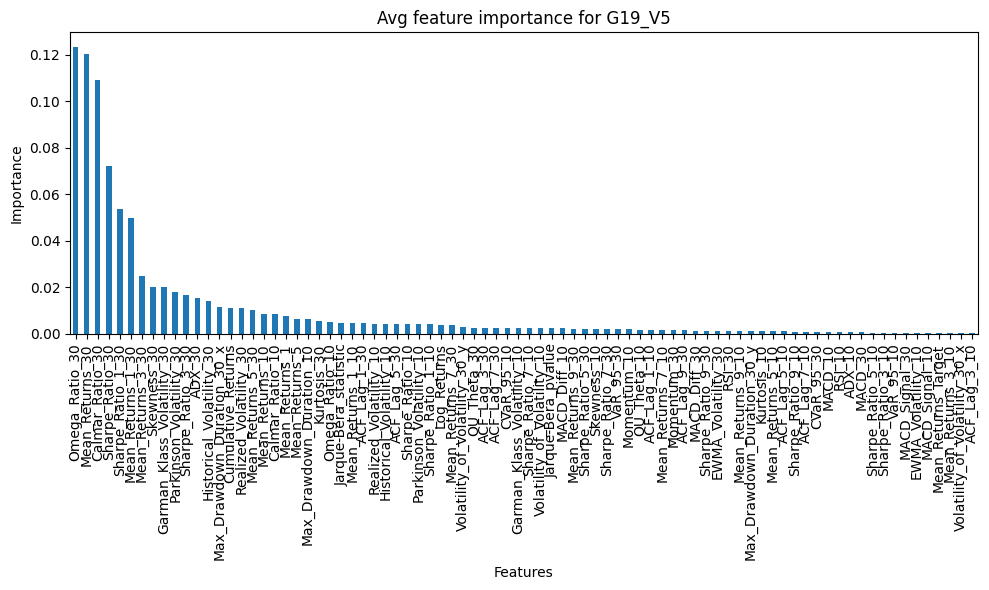

In [27]:
for strategy, importances in feature_importances_dict.items():
    importances.sort_values(ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 6))
    importances.plot(kind='bar')
    plt.title(f'Avg feature importance for {strategy}')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.savefig(f'graph/feature_importance/{strategy}.png
    plt.show()

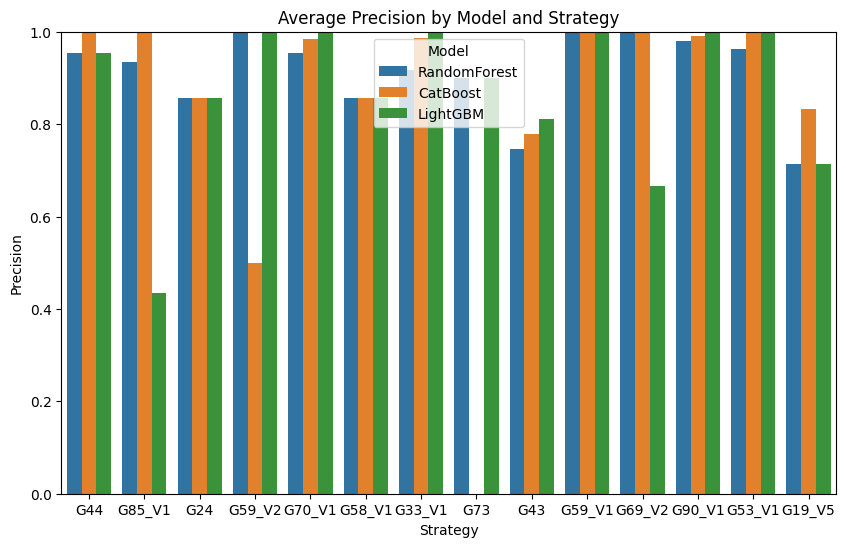

In [18]:
average_metrics_sharpe = compute_average_metrics(results_sharpe)
plot_average_metrics(average_metrics_sharpe, 'Precision')

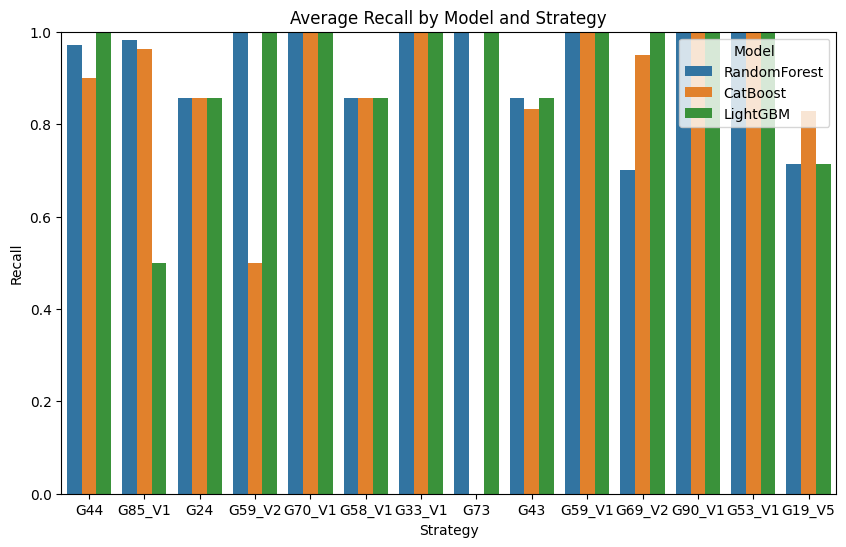

In [19]:
average_metrics_sharpe = compute_average_metrics(results_sharpe)
plot_average_metrics(average_metrics_sharpe, 'Recall')